 # Notebook description
I started the exploration from the central flight database, in which I focused in particular on the dep_delay variable (according to the documentation at the source), which informs about the amount of delay in the departure of the plane. Carrying out the next steps, I first properly prepared the initial data set for analysis, and then began to enrich it with additional information, e.g. weather information.

In [6]:
import psycopg2
from psycopg2 import connect
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pandas as pd
import os

In [7]:
username = 'DB_ID'
password = 'DB_PASS'
host = 'localhost'
database = 'airlines'
port = 5432

In [8]:
url = URL.create(
    "postgresql+psycopg2",
    database = database,
    username=username,
    password=password,
    host=host,
    port=port  
)
engine = create_engine(url)

In [9]:
# implementation of the read_sql_table method
def read_sql_table(table_name):
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(query, con=engine)
        return df
    except Exception as e:
        print(f"An error occurred while loading data from the database: {e}")
        return pd.DataFrame()  


In [10]:
# loading the frame into the workspace
table_name = 'flight'
flight_df_raw = read_sql_table(table_name)
flight_df_raw

id  month  day_of_month  day_of_week op_unique_carrier tail_num  \
0              1      1            20            7                WN   N204WN   
1              2      1            20            7                WN   N8682B   
2              3      1            20            7                WN   N717SA   
3              4      1            20            7                WN   N709SW   
4              5      1            20            7                WN   N7864B   
...          ...    ...           ...          ...               ...      ...   
1386115  1386116      3            26            4                DL   N350DN   
1386116  1386117      3            26            4                DL   N908DE   
1386117  1386118      3            26            4                DL     None   
1386118  1386119      3            26            4                DL   N352NW   
1386119  1386120      3            26            4                DL   N352DN   

         op_carrier_fl_num  origin_airport_id  dest_airport_id  crs_dep_time  \
0                      682              10397            11292           605   
1                     2622              10397            11292          2120   
2                     2939              10397            11292          1800   
3                     3848              10397            11292          1355   
4                     1352              10397            11697          1125   
...                    ...                ...              ...           ...   
1386115               1982              13303            12953          1956   
1386116               1987              13303            10397          1120   
1386117               1998              13303            10397          1817   
1386118               2025              13303            10397          1937   
1386119               2151              13303            12953           700   

         ...  crs_elapsed_time  actual_elapsed_time distance  distance_group  \
0        ...               205                204.0     1199               5   
1        ...               210                205.0     1199               5   
2        ...               210                220.0     1199               5   
3        ...               205                204.0     1199               5   
4        ...               120                124.0      581               3   
...      ...               ...                  ...      ...             ...   
1386115  ...               183                169.0     1096               5   
1386116  ...               121                109.0      594               3   
1386117  ...               125                  NaN      594               3   
1386118  ...               123                107.0      594               3   
1386119  ...               183                  NaN     1096               5   

         year  carrier_delay weather_delay  nas_delay  security_delay  \
0        2019            NaN           NaN        NaN             NaN   
1        2019            NaN           NaN        NaN             NaN   
2        2019            4.0           0.0       10.0             0.0   
3        2019            NaN           NaN        NaN             NaN   
4        2019            NaN           NaN        NaN             NaN   
...       ...            ...           ...        ...             ...   
1386115  2020            NaN           NaN        NaN             NaN   
1386116  2020            NaN           NaN        NaN             NaN   
1386117  2020            NaN           NaN        NaN             NaN   
1386118  2020            NaN           NaN        NaN             NaN   
1386119  2020            NaN           NaN        NaN             NaN   

         late_aircraft_delay  
0                        NaN  
1                        NaN  
2                        3.0  
3                        NaN  
4                        NaN  
...                      ...  
1386115                  

In [11]:
# Filter data by removing flights from 2020 and canceled flights
cleaned_df = flight_df_raw[(flight_df_raw['year'] != 2020) & (flight_df_raw['cancelled'] == 0)]

In [12]:
# renaming column `dep_delay_new` to `dep_delay`
flight_df = cleaned_df.rename(columns={'dep_delay_new': 'dep_delay'})
print(flight_df.columns)

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'year', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay'],
      dtype='object')


In [13]:
# Check if there are any flights from 2020 in the frame
flight_df_year_test = flight_df.loc[flight_df['year'] == 2020].shape[0]
assert flight_df_year_test == 0, 'The `flight_df` frame still contains flights from 2020.'

In [14]:
# Check if there are any canceled flights in the frame
flight_df_cancelled_test = flight_df.loc[flight_df['cancelled'] != 0].shape[0]
assert flight_df_cancelled_test == 0, 'There are still canceled flights in the `flight_df` frame.'

 # Analysis of the `dep_delay` column part 1
 I determined the descriptive statistics for the `dep_delay` variable and saved it to the `dep_delay_statistics_df` variable.
 The frame contains the following lines:
 - mean,
 - median,
 - standard deviation,
 - min, max
 - percentiles `[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]`

I rounded the results to two decimal places.

In [15]:
dep_delay_statistics_df = flight_df['dep_delay'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
dep_delay_statistics_df = dep_delay_statistics_df.round(2)
dep_delay_statistics_df

count    1095742.00
mean          14.77
std           46.49
min            0.00
10%            0.00
25%            0.00
50%            0.00
75%            8.00
90%           42.00
95%           81.00
99%          206.00
max         1959.00
Name: dep_delay, dtype: float64

 # Analysis of the `dep_delay` column part 2
 I analyzed the `dep_delay` column further by following the steps below:
 1. I plotted the graph for _the entire column_ (i.e. as it is).
 2. I plotted the chart by omitting the rows for which `dep_delay=0`.
 3. I plotted the chart to the 95% percentile and omitting `dep_delay=0`.

For all the charts, I used a histogram with bins of 10, i.e. `[0, 10)`, `[10, 20)` and so on.

Plots using the `matplotlib` library. 

In [16]:
import matplotlib.pyplot as plt
import seaborn as sbn

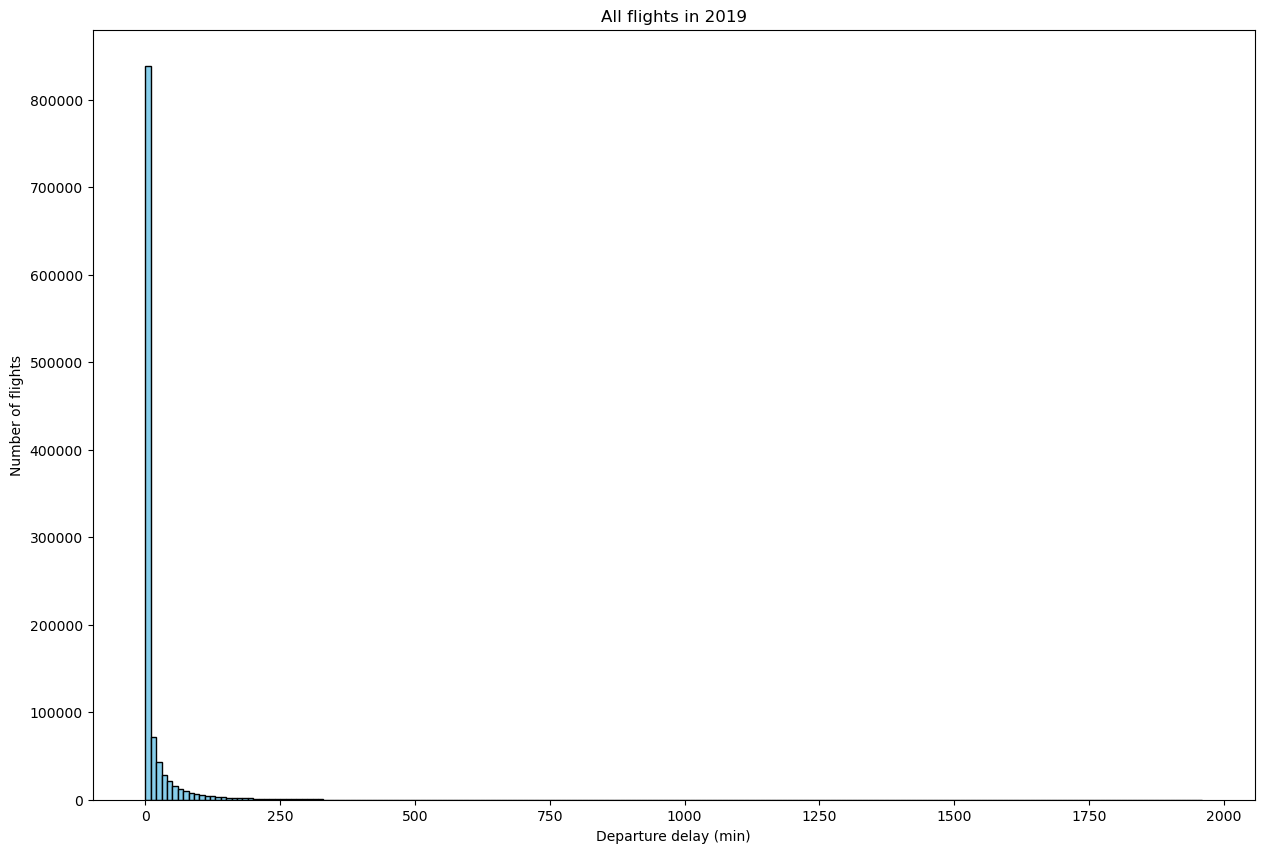

In [17]:
# graph for the entire dep_delay column
plt.figure(figsize=(15,10))
 
plt.hist(flight_df['dep_delay'], bins=range(int(flight_df['dep_delay'].min()), int(flight_df['dep_delay'].max()) + 10, 10), edgecolor='black', color='skyblue')
plt.title('All flights in 2019')  
plt.xlabel('Departure delay (min)')  
plt.ylabel('Number of flights')  

plt.show()

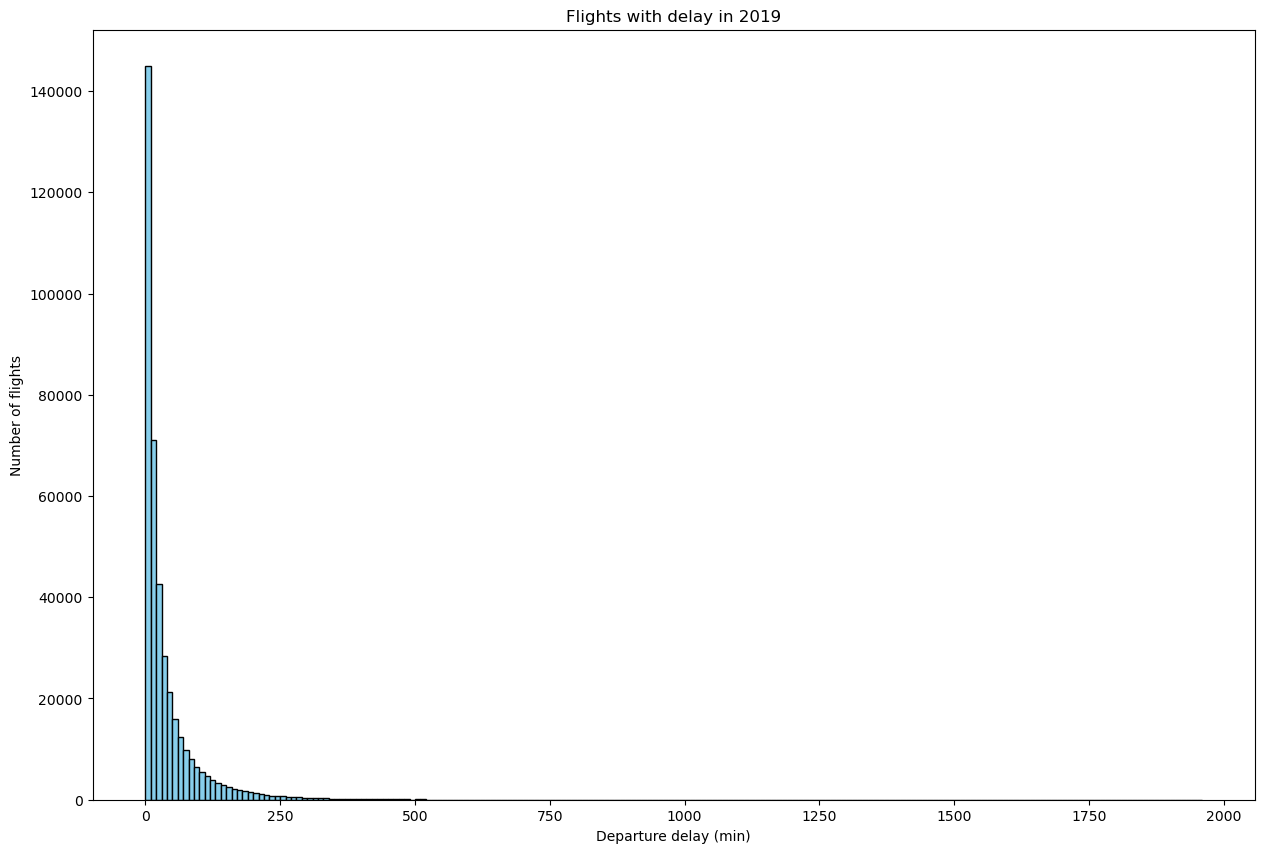

In [18]:
# graph for dep_delay > 0
delay_fig2 = flight_df[flight_df['dep_delay'] > 0]

plt.figure(figsize=(15,10))
 
plt.hist(delay_fig2['dep_delay'], bins=range(0, int(delay_fig2['dep_delay'].max()) + 10, 10), edgecolor='black', color='skyblue')
plt.title('Flights with delay in 2019')  
plt.xlabel('Departure delay (min)')  
plt.ylabel('Number of flights')  

plt.show()

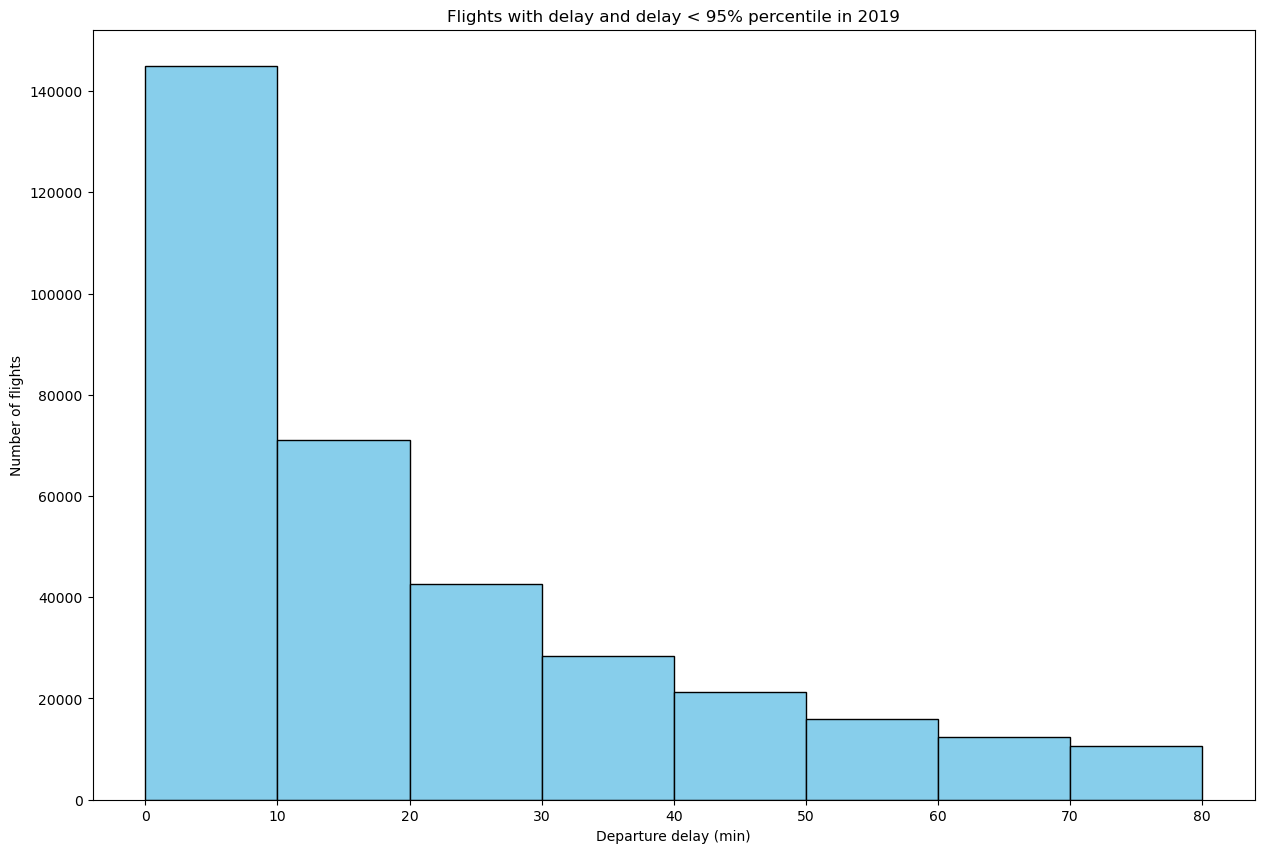

In [19]:
# graph for dep_delay > 0 and dep_delay < percentile 95%
percentile_95 = dep_delay_statistics_df['95%']
delay_fig3 = flight_df[(flight_df['dep_delay'] > 0) & (flight_df['dep_delay'] < percentile_95)]

plt.figure(figsize=(15,10))
 
plt.hist(delay_fig3['dep_delay'], bins=range(0, int(delay_fig3['dep_delay'].max()) + 10, 10), edgecolor='black', color='skyblue')
plt.title('Flights with delay and delay < 95% percentile in 2019')  
plt.xlabel('Departure delay (min)')  
plt.ylabel('Number of flights')  

plt.show()

 # Delay analysis
in the flight_df frame I created a new column - is_delayed as those delays that were more than (>) 15 minutes.
Then I determined what percentage of all flights were delayed.

In [20]:
flight_df['is_delayed'] = flight_df['dep_delay'] > 15
flight_df.head()

id  month  day_of_month  day_of_week op_unique_carrier tail_num  \
0   1      1            20            7                WN   N204WN   
1   2      1            20            7                WN   N8682B   
2   3      1            20            7                WN   N717SA   
3   4      1            20            7                WN   N709SW   
4   5      1            20            7                WN   N7864B   

   op_carrier_fl_num  origin_airport_id  dest_airport_id  crs_dep_time  ...  \
0                682              10397            11292           605  ...   
1               2622              10397            11292          2120  ...   
2               2939              10397            11292          1800  ...   
3               3848              10397            11292          1355  ...   
4               1352              10397            11697          1125  ...   

   actual_elapsed_time  distance distance_group  year  carrier_delay  \
0                204.0      1199              5  2019            NaN   
1                205.0      1199              5  2019            NaN   
2                220.0      1199              5  2019            4.0   
3                204.0      1199              5  2019            NaN   
4                124.0       581              3  2019            NaN   

   weather_delay nas_delay  security_delay  late_aircraft_delay  is_delayed  
0            NaN       NaN             NaN                  NaN       False  
1            NaN       NaN             NaN                  NaN       False  
2            0.0      10.0             0.0                  3.0       False  
3            NaN       NaN             NaN                  NaN       False  
4            NaN       NaN             NaN                  NaN       False  

[5 rows x 29 columns]

In [21]:
delayed_ratio = (flight_df['is_delayed'].mean()).round(2)

print(f"Percentage of delayed flights: {delayed_ratio * 100}%")

Percentage of delayed flights: 19.0%


 # Delays vs. calendar month
We examined how the percentage of delays changes depending on the calendar month. First, I created the flight_delays_by_month_df variable using the groupby method. Then
I generated a chart based on the flight_delays_by_month_df variable.

In [22]:
# grouping data into the flight_delays_by_month_df frame
flight_delays_by_month_df = flight_df.groupby('month')['is_delayed'].mean() * 100

# Transform series back to DataFrame and reset index for easier plotting
flight_delays_by_month_df = flight_delays_by_month_df.reset_index()
flight_delays_by_month_df.rename(columns={'is_delayed': 'percentage_delayed'}, inplace=True)

flight_delays_by_month_df.round(2)

month  percentage_delayed
0       1               18.08
1       2               21.86
2       3               17.61
3       4               18.28
4       5               20.47
5       6               24.76
6       7               21.67
7       8               21.03
8       9               14.77
9      10               16.35
10     11               13.92
11     12               20.79

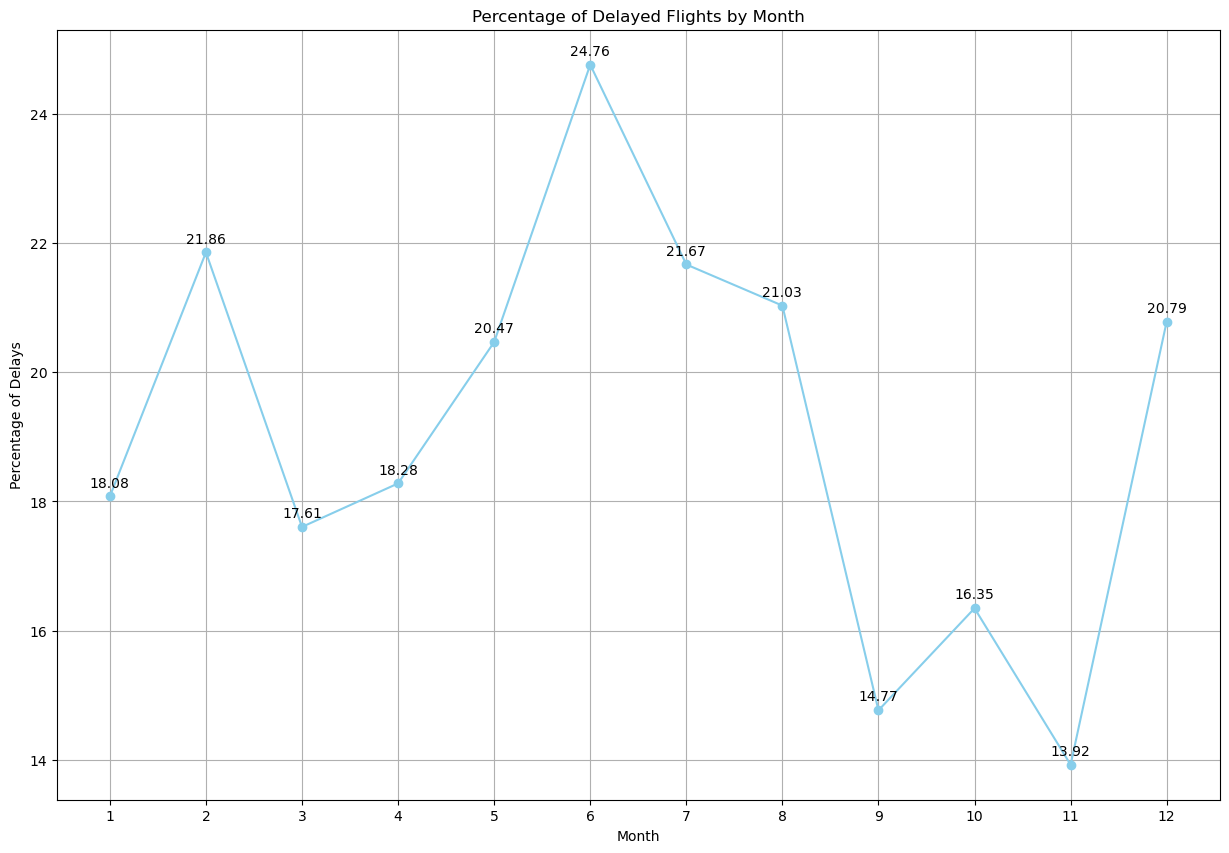

In [25]:
plt.figure(figsize=(15, 10))
# bars = plt.bar(flight_delays_by_month_df['month'], flight_delays_by_month_df['percentage_delayed'], color='skyblue')

plt.plot(flight_delays_by_month_df['month'], flight_delays_by_month_df['percentage_delayed'], marker='o', color='skyblue')
plt.title('Percentage of Delayed Flights by Month')
plt.xlabel('Month')
plt.ylabel('Percentage of Delays')
plt.grid(True)
plt.xticks(flight_delays_by_month_df['month'])  # Assurance that all months are shown

# Adding labels above the posts
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')
plt.show()

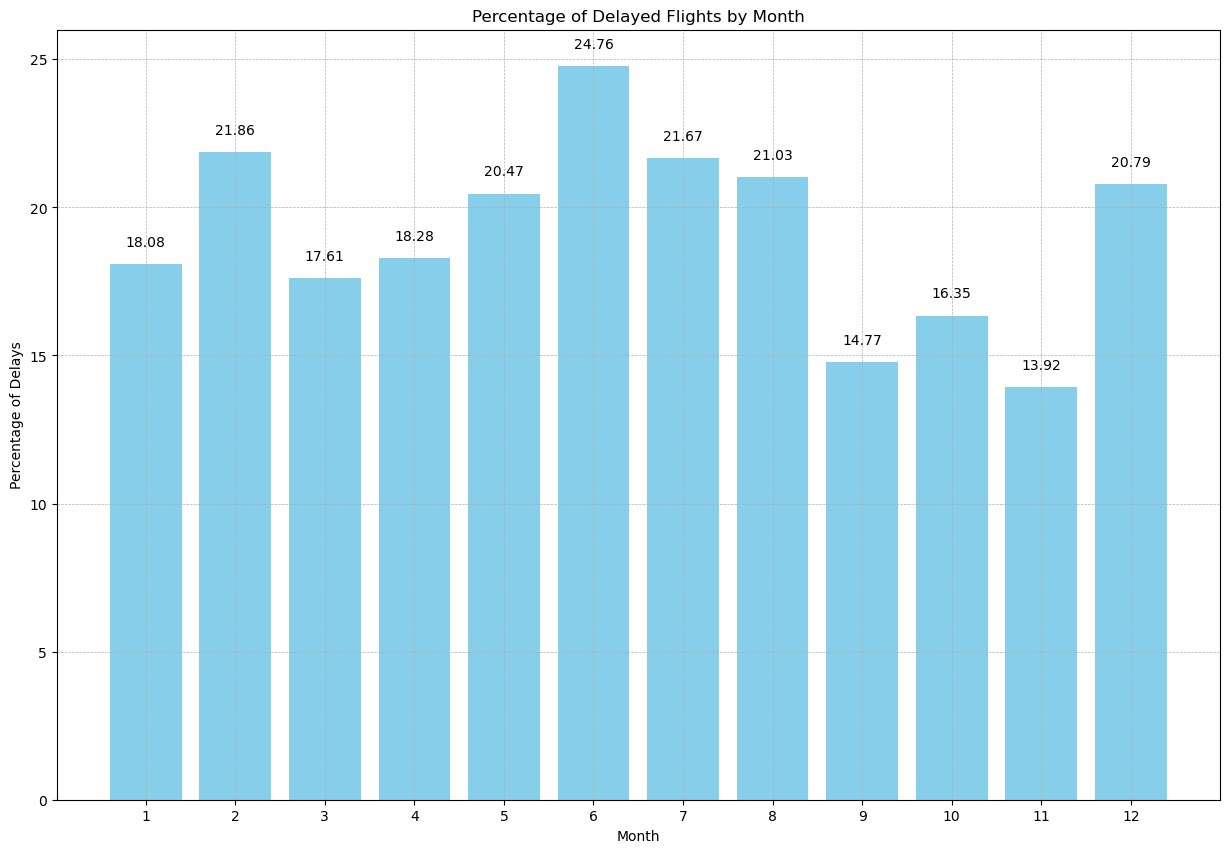

In [26]:
plt.figure(figsize=(15, 10))
bars = plt.bar(flight_delays_by_month_df['month'], flight_delays_by_month_df['percentage_delayed'], color='skyblue')

plt.xlabel('Month')
plt.ylabel('Percentage of Delays')
plt.title('Percentage of Delayed Flights by Month')
plt.xticks(flight_delays_by_month_df['month'])  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.show()

 # Delays vs. day of the week part 1
percentage of delays depending on the day of the week.

In [27]:
flight_delays_by_weekday_df = flight_df.groupby('day_of_week')['is_delayed'].mean() * 100

flight_delays_by_weekday_df = flight_delays_by_weekday_df.reset_index()
flight_delays_by_weekday_df.rename(columns={'is_delayed': 'percentage_delayed'}, inplace=True)

flight_delays_by_weekday_df.round(2)

day_of_week  percentage_delayed
0            1               20.13
1            2               17.48
2            3               18.28
3            4               21.22
4            5               20.32
5            6               16.78
6            7               19.24

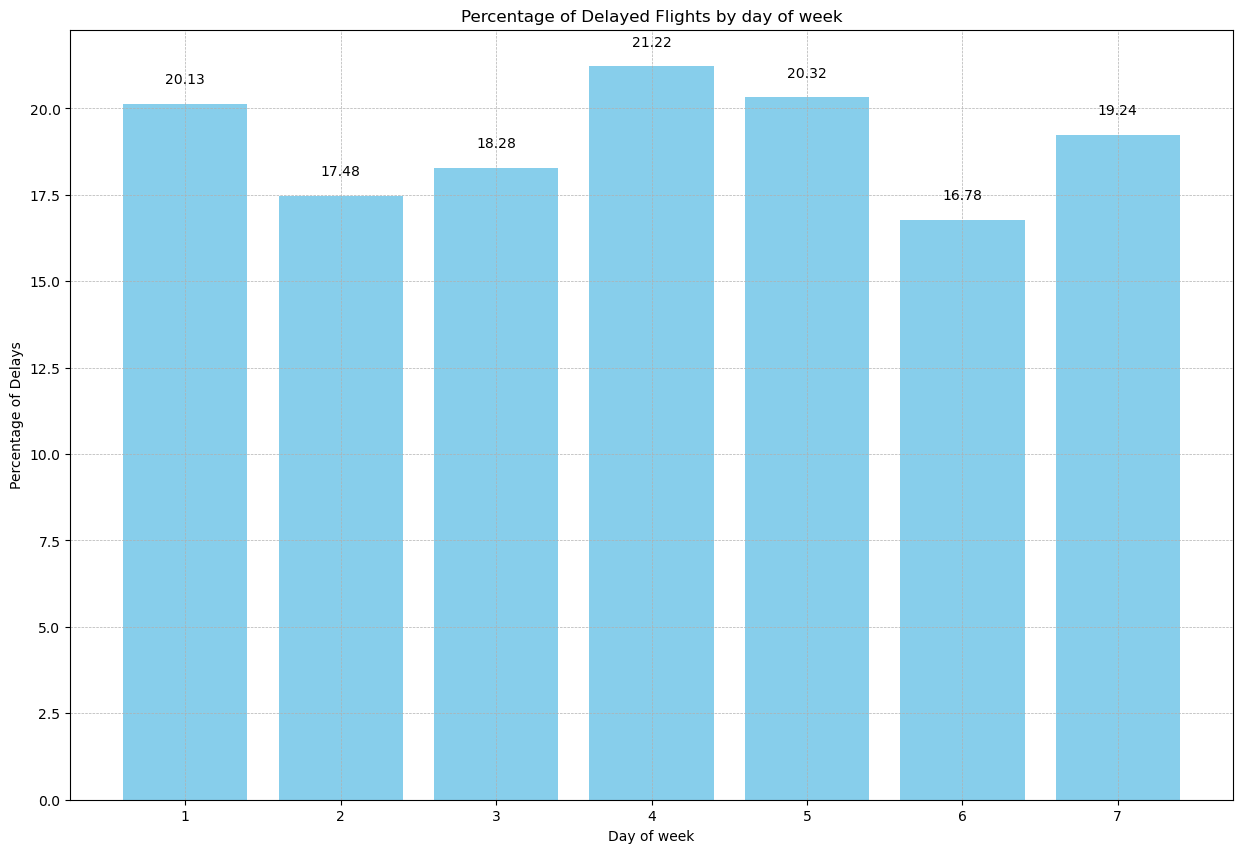

In [28]:
plt.figure(figsize=(15, 10))
bars = plt.bar(flight_delays_by_weekday_df['day_of_week'], flight_delays_by_weekday_df['percentage_delayed'], color='skyblue')

plt.xlabel('Day of week')
plt.ylabel('Percentage of Delays')
plt.title('Percentage of Delayed Flights by day of week')
plt.xticks(flight_delays_by_weekday_df['day_of_week']) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.show()

 # Delays vs. day of the week part 2
Aggregating column `day_of_week` to new column `is_weekend` in `flight_df`

In [29]:
# Add new column 'is_weekend'
flight_df['is_weekend'] = flight_df['day_of_week'].apply(lambda x: 1 if x in [6, 7] else 0)
print(flight_df[['day_of_week', 'is_weekend']])

         day_of_week  is_weekend
0                  7           1
1                  7           1
2                  7           1
3                  7           1
4                  7           1
...              ...         ...
1382982            3           0
1382983            3           0
1382984            3           0
1382985            3           0
1382986            3           0

[1095742 rows x 2 columns]


In [30]:
# Group the data by whether the flight took place on a weekend and calculate the percentage of delays
flight_delays_by_weekend_df = flight_df.groupby('is_weekend')['is_delayed'].mean()
flight_delays_by_weekend_df = flight_delays_by_weekend_df.round(2)
flight_delays_by_weekend_df

is_weekend
0    0.19
1    0.18
Name: is_delayed, dtype: float64

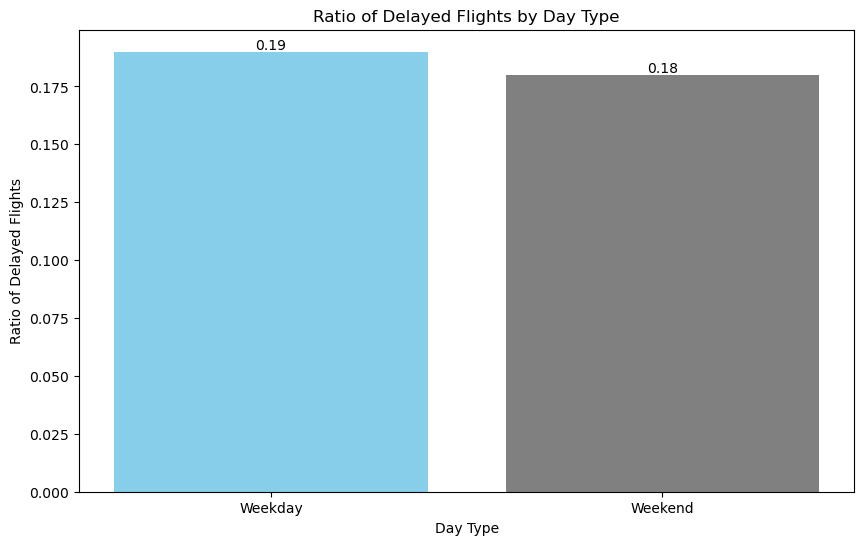

In [31]:
# graph for flight_delays_by_weekend_df
fig_flight_delays_by_weekend_df = flight_delays_by_weekend_df.reset_index()
fig_flight_delays_by_weekend_df.columns = ['is_weekend', 'is_delayed']

plt.figure(figsize=(10, 6))
plt.bar(fig_flight_delays_by_weekend_df.index.map({0: 'Weekday', 1: 'Weekend'}),
        fig_flight_delays_by_weekend_df['is_delayed'], color=['skyblue', 'grey'])

plt.title('Ratio of Delayed Flights by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Ratio of Delayed Flights')

for i, v in enumerate(fig_flight_delays_by_weekend_df['is_delayed']):
    plt.text(i, v + 0.001, f"{v}", ha='center')

plt.show()

 # Delays vs. flight distance
Distance column analysis:
1. Descriptive statistics and percentiles [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]. Saved to the flight_distance_analysis_df.
2. Scatterplot for distance and dep_delay. Graph for random 10 thousand rows.
3. Removing lines from the flight_df for which distance is above the 95% percentile.
4. Using the flight_df, I aggregated the distance variable every 100 miles into a new distance_agg column and determined the percentage of delays in each bucket. The result saved to flight_delays_by_distance_agg_df.
5. Bar chart for data stored in flight_delays_by_distance_agg_df.

In [32]:
flight_distance_analysis_df = flight_df['distance'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)
flight_distance_analysis_df

count    1095742.00
mean         758.08
std          600.43
min          100.00
10%          216.00
25%          337.00
50%          606.00
75%          937.00
90%         1721.00
95%         2475.00
99%         2586.00
max         2586.00
Name: distance, dtype: float64

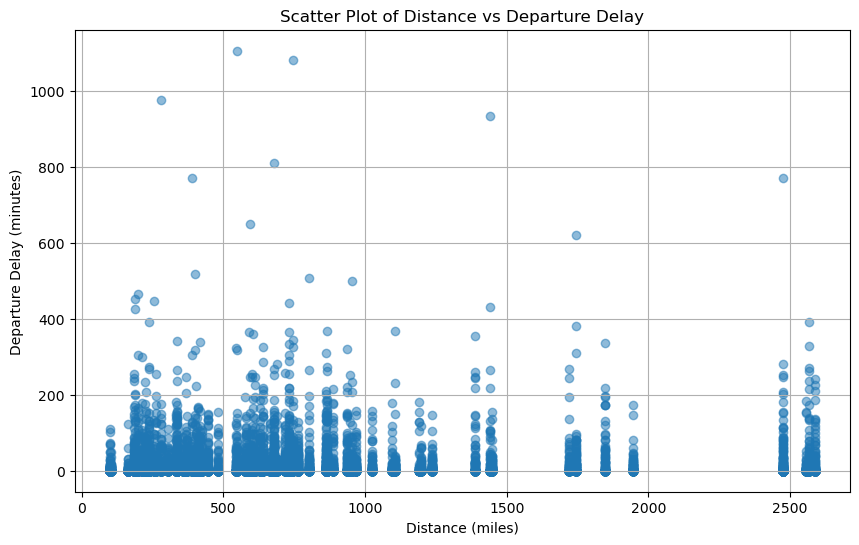

In [33]:
# plot for 10,000 random rows from the flight_df table
sample_df = flight_df.sample(n=10000, random_state=1)

plt.figure(figsize=(10, 6))
plt.scatter(sample_df['distance'], sample_df['dep_delay'], alpha=0.5)
plt.title('Scatter Plot of Distance vs Departure Delay')
plt.xlabel('Distance (miles)')
plt.ylabel('Departure Delay (minutes)')
plt.grid(True)
plt.show()

In [34]:
# Deleting rows where distance > 95% percentile
percentile_95 = flight_df['distance'].quantile(0.95)
flight_df = flight_df[flight_df['distance'] <= flight_df['distance'].quantile(0.95)] #percentile_95]

In [35]:
# Aggregate 'distance' every 100 miles and calculate delay percentage
flight_df['distance_agg'] = pd.cut(flight_df['distance'], bins=range(0, int(flight_df['distance'].max()) + 100, 100), right=False)
flight_delays_by_distance_agg_df = flight_df.groupby('distance_agg')['dep_delay'].apply(lambda x: (x > 15).mean()).round(2).reset_index()
flight_delays_by_distance_agg_df

/var/folders/4b/s0nmq1nn56s7pq1gdy7fqt000000gp/T/ipykernel_71280/464337112.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flight_delays_by_distance_agg_df = flight_df.groupby('distance_agg')['dep_delay'].apply(lambda x: (x > 15).mean()).round(2).reset_index()


distance_agg  dep_delay
0       [0, 100)        NaN
1     [100, 200)       0.12
2     [200, 300)       0.19
3     [300, 400)       0.20
4     [400, 500)       0.17
5     [500, 600)       0.17
6     [600, 700)       0.20
7     [700, 800)       0.24
8     [800, 900)       0.21
9    [900, 1000)       0.22
10  [1000, 1100)       0.20
11  [1100, 1200)       0.19
12  [1200, 1300)       0.21
13  [1300, 1400)       0.25
14  [1400, 1500)       0.16
15  [1500, 1600)        NaN
16  [1600, 1700)        NaN
17  [1700, 1800)       0.21
18  [1800, 1900)       0.27
19  [1900, 2000)       0.20
20  [2000, 2100)        NaN
21  [2100, 2200)        NaN
22  [2200, 2300)        NaN
23  [2300, 2400)        NaN
24  [2400, 2500)       0.17

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


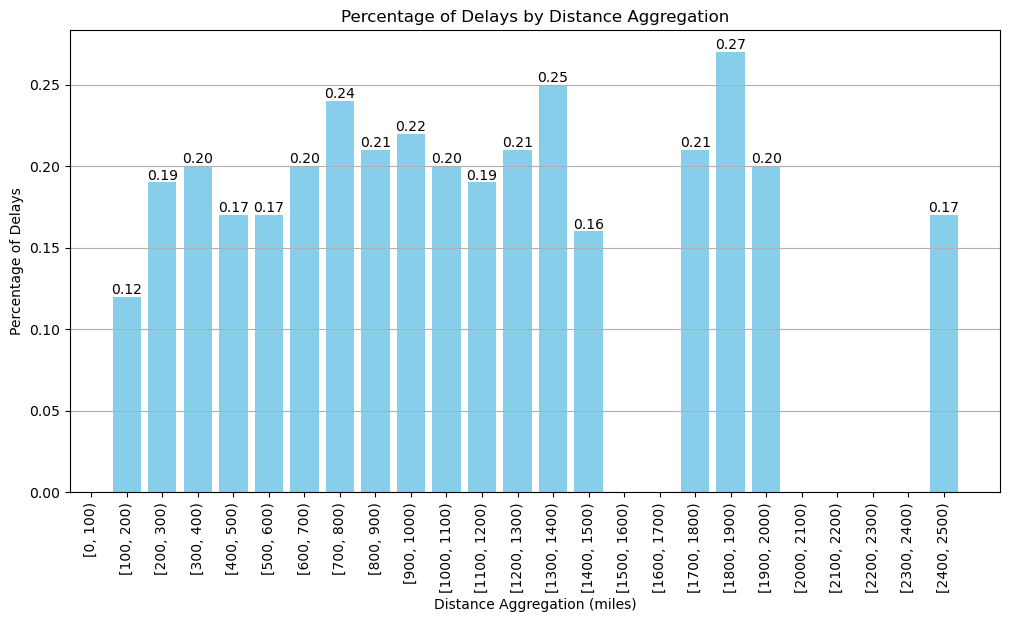

In [36]:
# chart of delay percentage versus distance aggregation
plt.figure(figsize=(12, 6))
bars = plt.bar(flight_delays_by_distance_agg_df['distance_agg'].astype(str), flight_delays_by_distance_agg_df['dep_delay'], color='skyblue')
plt.xticks(rotation=90)
plt.title('Percentage of Delays by Distance Aggregation')
plt.xlabel('Distance Aggregation (miles)')
plt.ylabel('Percentage of Delays')
plt.grid(axis='y')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

 # Delays vs. distance group

Analysis the distance_group column.

Tutaj wyznacz odcinki, dla których zostały wyznaczone poszczególne grupy

In [37]:
# Aggregate the minimum and maximum distance values for each distance group
flight_distance_by_distance_group = flight_df.groupby('distance_group')['distance'].agg(['min', 'max']).reset_index()
flight_distance_by_distance_group.rename(columns={'min': 'min_distance', 'max': 'max_distance'}, inplace=True)
flight_distance_by_distance_group

distance_group  min_distance  max_distance
0               1           100           239
1               2           255           480
2               3           544           746
3               4           762           967
4               5          1024          1235
5               6          1389          1448
6               7          1721          1744
7               8          1846          1947
8              10          2475          2475

In [38]:
# Calculate the delay probability for each distance_group
flight_delays_by_distance_group_df = flight_df.groupby('distance_group')['is_delayed'].mean().reset_index()
flight_delays_by_distance_group_df.rename(columns={'is_delayed': 'delay_probability'}, inplace=True)
flight_delays_by_distance_group_df['delay_probability'] = flight_delays_by_distance_group_df['delay_probability'].round(2)
flight_delays_by_distance_group_df

distance_group  delay_probability
0               1               0.16
1               2               0.19
2               3               0.20
3               4               0.22
4               5               0.20
5               6               0.19
6               7               0.21
7               8               0.24
8              10               0.17

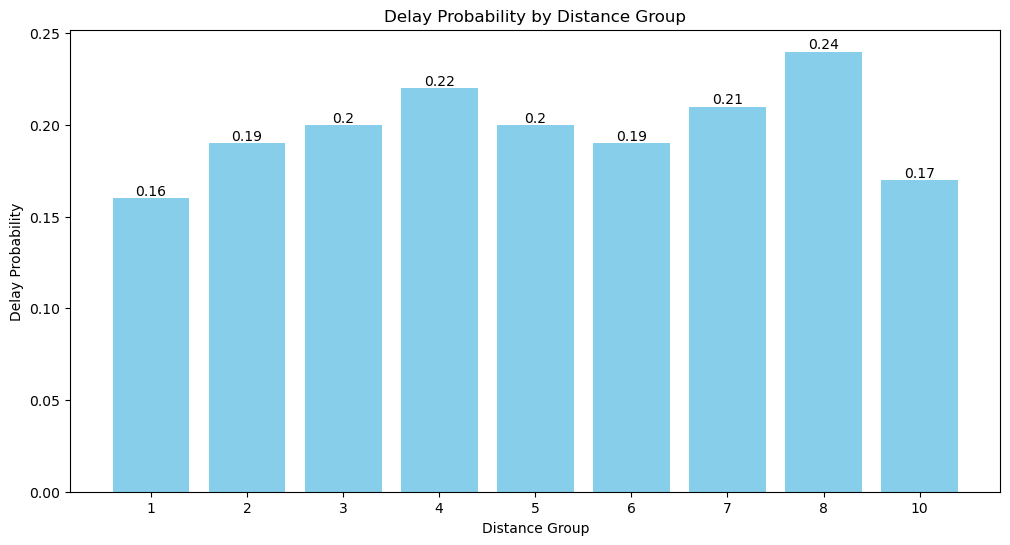

In [39]:
# Create a bar chart

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(flight_delays_by_distance_group_df['distance_group'])), flight_delays_by_distance_group_df['delay_probability'], color='skyblue')

plt.xticks(ticks=range(len(flight_delays_by_distance_group_df['distance_group'])), labels=flight_delays_by_distance_group_df['distance_group'])

plt.xlabel('Distance Group')
plt.ylabel('Delay Probability')
plt.title('Delay Probability by Distance Group')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

In [43]:
result_data_path = "./result"
isExist = os.path.exists(result_data_path)
print(isExist)

False


In [44]:
if not isExist:
    os.makedirs(result_data_path)

In [45]:
flight_df.to_csv(f'{result_data_path}/flight_df_01.csv', index=False)